In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm, norm
from datetime import datetime, timedelta

In [2]:
# ---------------- Helper Function ---------------- #
def nearest_positive_definite(mat):
    from numpy.linalg import svd, eigvals, cholesky
    B = (mat + mat.T) / 2
    _, s, V = svd(B)
    H = V.T @ np.diag(s) @ V
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2

    def is_pd(x):
        try:
            cholesky(x)
            return True
        except np.linalg.LinAlgError:
            return False

    k = 0
    spacing = np.spacing(np.linalg.norm(mat))
    while not is_pd(A3):
        k += 1
        mineig = np.min(np.real(eigvals(A3)))
        A3 += np.eye(mat.shape[0]) * (-mineig * k**2 + spacing)
    return A3

### Parameter Set Up #

In [3]:
# Commodities and parameters
tickers = ["Crude", "LPG", "LNG", "Gasoline", "Jet", "Naphtha", "BFO"]
weights = np.array([0.3, 0.1, 0.1, 0.15, 0.15, 0.1, 0.1])
    
# Annual vols: Crude:35%, LPG:45%, LNG:50%, Gasoline:40%, Jet:42%, Naphtha:38%, BFO:30%
sigma = np.array([0.35/np.sqrt(252), 0.45/np.sqrt(252), 0.50/np.sqrt(252),
                     0.40/np.sqrt(252), 0.42/np.sqrt(252), 0.38/np.sqrt(252), 
                     0.30/np.sqrt(252)])
    
commodity_params = {
        "Crude": {"base_price": 80, "vol": sigma[0], "mean_rev": 0.05, "skew": 0.2},
        "LPG": {"base_price": 30, "vol": sigma[1], "mean_rev": 0.08, "skew": 0.3},
        "LNG": {"base_price": 13, "vol": sigma[2], "mean_rev": 0.1, "skew": 0.4},
        "Gasoline": {"base_price": 92, "vol": sigma[3], "mean_rev": 0.06, "skew": 0.25},
        "Jet": {"base_price": 2, "vol": sigma[4], "mean_rev": 0.07, "skew": 0.3},
        "Naphtha": {"base_price": 525, "vol": sigma[5], "mean_rev": 0.07, "skew": 0.35},
        "BFO": {"base_price": 523, "vol": sigma[6], "mean_rev": 0.04, "skew": 0.15}
    }


cor_matrix = np.array([
        [1.00, 0.65, 0.40, 0.85, 0.80, 0.78, 0.70],
        [0.65, 1.00, 0.30, 0.60, 0.58, 0.57, 0.55],
        [0.40, 0.30, 1.00, 0.35, 0.32, 0.30, 0.28],
        [0.85, 0.60, 0.35, 1.00, 0.82, 0.80, 0.72],
        [0.80, 0.58, 0.32, 0.82, 1.00, 0.83, 0.74],
        [0.78, 0.57, 0.30, 0.80, 0.83, 1.00, 0.75],
        [0.70, 0.55, 0.28, 0.72, 0.74, 0.75, 1.00],
    ])

cov_matrix = np.outer(sigma, sigma) * cor_matrix

### Price Simulation ###


In [4]:
def simulate_energy_prices(n_days=252*5, n_assets=7, seed=42):
    np.random.seed(seed)
    
    # Generate correlated returns with mean reversion and skewness
    chol = np.linalg.cholesky(cor_matrix)
    prices = np.zeros((n_days, n_assets))
    returns = np.zeros((n_days, n_assets))
    
    # Initialize prices
    for i, ticker in enumerate(tickers):
        prices[0, i] = commodity_params[ticker]["base_price"]
    
    for t in range(1, n_days):
        # Generate skewed random numbers
        z = np.zeros(n_assets)
        for i, ticker in enumerate(tickers):
            skew = commodity_params[ticker]["skew"]
            z[i] = skewnorm.rvs(skew)
        
        # Correlate them
        correlated_z = np.dot(z, chol.T)
        
        # Update prices
        for i, ticker in enumerate(tickers):
            params = commodity_params[ticker]
            mu = np.log(params["base_price"])
            current_log_price = np.log(prices[t-1, i])
            drift = params["mean_rev"] * (mu - current_log_price)
            shock = params["vol"] * correlated_z[i]
            
            new_log_price = current_log_price + drift + shock
            prices[t, i] = np.exp(new_log_price)
            returns[t, i] = (prices[t, i] / prices[t-1, i]) - 1
    
    # Create DataFrames
    date_index = pd.date_range(end=datetime.today(), periods=n_days, freq='B')
    price_df = pd.DataFrame(prices, columns=tickers, index=date_index)
    returns_df = pd.DataFrame(returns, columns=tickers, index=date_index)
    
    return price_df, returns_df, weights

### Risk Calculations ###

In [5]:
def calculate_var_cvar(returns, weights, cov_matrix, portfolio_value=1_000_000, confidence_levels=[0.95, 0.99]):
    results = []
    for cl in confidence_levels:
        # 1. Simulated Path VaR/CVaR (non-parametric)
        sorted_returns = np.sort(returns)
        var_sim_pct = -np.percentile(sorted_returns, 100*(1-cl))
        cvar_sim_pct = -sorted_returns[sorted_returns <= -var_sim_pct].mean()
        
        # 2. Delta-Normal VaR/CVaR (parametric)
        portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        var_dn_pct = -norm.ppf(1-cl) * portfolio_vol
        cvar_dn_pct = (norm.pdf(norm.ppf(cl)) / (1-cl)) * portfolio_vol
        
        # Convert to dollars
        var_sim_dollar = portfolio_value * var_sim_pct
        cvar_sim_dollar = portfolio_value * cvar_sim_pct
        var_dn_dollar = portfolio_value * var_dn_pct
        cvar_dn_dollar = portfolio_value * cvar_dn_pct
        
        results.append({
            "Confidence Level": f"{int(cl*100)}%",
            "Simulated VaR ($)": f"${var_sim_dollar:,.0f}",
            "Simulated CVaR ($)": f"${cvar_sim_dollar:,.0f}",
            "Delta-Normal VaR ($)": f"${var_dn_dollar:,.0f}",
            "Delta-Normal CVaR ($)": f"${cvar_dn_dollar:,.0f}",
            "Portfolio Vol (%)": f"{portfolio_vol:.2%}"
        })
    
    return pd.DataFrame(results)



### Stress Test ###

In [6]:
def stress_test(weights, initial_value=10_000_000, n_simulations=5000):
    stress_params = {
        "vol_multiplier": 3.0,
        "base_drop": np.array([-0.25, -0.30, -0.15, -0.35, -0.40, -0.25, -0.20]),
        "correlation_boost": 0.25
    }

    stressed_corr = np.minimum(
        np.array([
            [1.00, 0.70, 0.45, 0.85, 0.80, 0.75, 0.70],
            [0.70, 1.00, 0.35, 0.65, 0.60, 0.65, 0.60],
            [0.45, 0.35, 1.00, 0.40, 0.35, 0.40, 0.35],
            [0.85, 0.65, 0.40, 1.00, 0.85, 0.80, 0.75],
            [0.80, 0.60, 0.35, 0.85, 1.00, 0.75, 0.70],
            [0.75, 0.65, 0.40, 0.80, 0.75, 1.00, 0.80],
            [0.70, 0.60, 0.35, 0.75, 0.70, 0.80, 1.00]
        ]) + stress_params["correlation_boost"], 0.95
    )

    stressed_vols = sigma * stress_params["vol_multiplier"]
    stressed_cov = np.outer(stressed_vols, stressed_vols) * stressed_corr
    stressed_cov = nearest_positive_definite(stressed_cov)
    chol = np.linalg.cholesky(stressed_cov)

    random_draws = np.random.normal(size=(n_simulations, len(tickers)))
    simulated_returns = stress_params["base_drop"] + np.dot(random_draws, chol.T)
    portfolio_pnl = simulated_returns @ weights * initial_value

    var_95 = -np.percentile(portfolio_pnl, 5)
    cvar_95 = -portfolio_pnl[portfolio_pnl <= -var_95].mean()

    return {
        "var_95_usd": var_95,
        "cvar_95_usd": cvar_95,
        "mean_pnl_usd": portfolio_pnl.mean(),
        "portfolio_pnl": portfolio_pnl
    }


### Execution ###


=== RISK METRICS ===
Confidence Level Simulated VaR ($) Simulated CVaR ($) Delta-Normal VaR ($) Delta-Normal CVaR ($) Portfolio Vol (%)
             95%          $326,668           $406,745             $337,450              $423,176             2.05%
             99%          $447,134           $506,764             $477,262              $546,782             2.05%

=== STRESS TEST RESULTS ===
VaR 95%: $3,905,556
CVaR 95%: $4,207,663
Avg P&L: $-2,772,965


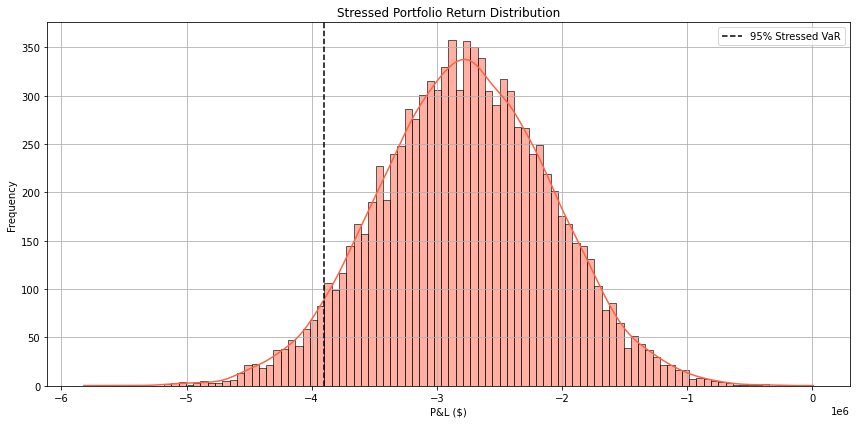

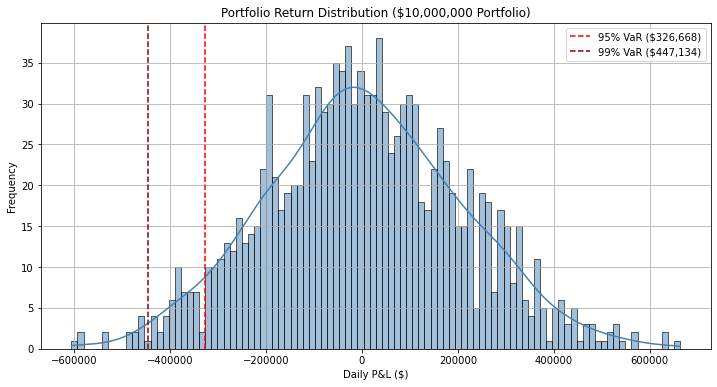

In [7]:
if __name__ == "__main__":
    portfolio_value = 10_000_000
    price_df, returns_df, weights = simulate_energy_prices()
    portfolio_returns = returns_df @ weights

    print("\n=== RISK METRICS ===")
    risk_results = calculate_var_cvar(portfolio_returns, weights, cov_matrix, portfolio_value)
    print(risk_results.to_string(index=False))

    print("\n=== STRESS TEST RESULTS ===")
    stress_results = stress_test(weights, initial_value=portfolio_value, n_simulations=10000)
    print(f"VaR 95%: ${stress_results['var_95_usd']:,.0f}")
    print(f"CVaR 95%: ${stress_results['cvar_95_usd']:,.0f}")
    print(f"Avg P&L: ${stress_results['mean_pnl_usd']:,.0f}")

    # Plot stress P&L distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(stress_results["portfolio_pnl"], bins=100, kde=True, color='tomato')
    plt.axvline(-stress_results["var_95_usd"], color='black', linestyle='--', label='95% Stressed VaR')
    plt.title("Stressed Portfolio Return Distribution")
    plt.xlabel("P&L ($)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot normal P&L distribution
    var_95_dollar = portfolio_value * -np.percentile(portfolio_returns, 5)
    var_99_dollar = portfolio_value * -np.percentile(portfolio_returns, 1)

    plt.figure(figsize=(12, 6))
    sns.histplot(portfolio_returns * portfolio_value, bins=100, kde=True, color='steelblue')
    plt.axvline(-var_95_dollar, color='red', linestyle='--', label=f'95% VaR (${var_95_dollar:,.0f})')
    plt.axvline(-var_99_dollar, color='darkred', linestyle='--', label=f'99% VaR (${var_99_dollar:,.0f})')
    plt.title(f"Portfolio Return Distribution (${portfolio_value:,.0f} Portfolio)")
    plt.xlabel("Daily P&L ($)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()